In [95]:
import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid
import logging
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import pickle
import matplotlib.image as mpimg

cutoff_train_test = 36+12

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred))) / np.mean(y_true) * 100

def is_cold(el):
    return (el.month > 10 or el.month < 3)

# add "is cold" and concatenate with another time series, if provided (for external regressors)
def prepare_time_series(df, original_df = None):
    df['is_cold'] = df['ds'].apply(is_cold)
    df['is_not_cold'] = ~df['ds'].apply(is_cold)
    if original_df is not None:
        original_df_restricted = original_df.loc[df.index.min():df.index.max(),:]
        return pd.concat([df, original_df_restricted], axis=1)
        
    return df

def make_single_df(prof, df_sales, df_external = None):
    if df_external is not None:
            df = pd.concat([df_sales, df_external], axis=1)
    else:
            df = df_sales
    df['ds'] = df.index
    df['y']=df['Sales']
    df = prepare_time_series(df)
    train_df = df

    future = prof.make_future_dataframe(periods=cutoff_train_test, freq = 'MS')
    future['Date'] = future['ds']
    future.set_index('Date', inplace=True)
    if df_external is not None:
            future = prepare_time_series(future, df[df_external.columns])
    else:
            future = prepare_time_series(future)

    forecast = prof.predict(future)
    forecast['Date'] = forecast['ds']
    forecast.set_index('Date', inplace=True)

    viz_df = train_df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
    viz_df.loc[:,'y'] = df_sales.loc[:,'Sales']
    viz_df[df_external.columns] = df_external[df_external.columns]
    viz_df.loc[:,'ds'] = df_external.index
    viz_df = prepare_time_series(viz_df)
    return viz_df

def plot_verif(verif, cutoff, ax, title=None, predcol='yhat',lower='yhat_lower', upper='yhat_upper'):
    train = verif[:-cutoff]
    ax.plot(train.index, train.y, 'ko', markersize=3)
    ax.plot(train.index, train[predcol], color='steelblue', lw=0.5)
    ax.fill_between(train.index, train[lower], train[upper], color='steelblue', alpha=0.3)
    test = verif[-cutoff-1:]
    ax.plot(test.index, test.y, 'ro', markersize=3)
    ax.plot(test.index, test[predcol], color='coral', lw=0.5)
    ax.fill_between(test.index, test[lower], test[upper], color='coral', alpha=0.3)
    ax.axvline(test.index.min(), color='0.8', alpha=0.7)
    ax.grid(ls=':', lw=0.5)
    if title is not None: 
        ax.set_title(title, fontsize=16)


def plot_joint_plot(verif, x='yhat', y='y', title=None,cutoff=cutoff_train_test, xlim=[0, 4e7], ylim=[0, 4e7], text_offset=-1e7): 
    train = verif[:-cutoff]
    test = verif[-cutoff-1:]

    g = sns.jointplot(x=x, y=y, data = verif, kind="reg", scatter=False)
    sns.scatterplot(x=x, y=y, data=train, color='blue', ax=g.ax_joint, label='train set')
    g.ax_joint.axline((0, 0), slope=1, color='green',linestyle="--", label="ideal match line")
    g.ax_joint.legend()
    g.fig.set_figwidth(8)
    g.fig.set_figheight(8)
    ax = g.fig.axes[1]
    ax.set_xlim(xlim)

    if title is not None: 
        ax.set_title(title, fontsize=16)
    ax = g.fig.axes[0]

    ax.set_xlabel("model's estimates", fontsize=15)
    ax.set_ylabel("observations", fontsize=15)
    ax.set_ylim(ylim)

    ax.grid(ls=':')
    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];
    ax.grid(ls=':')
    return g

def plot_single(viz_df, pred1='yhat', pred1_lower='yhat_lower',pred1_upper='yhat_upper', title1="Prophet prediction", text_offset=0):
    f, axes = plt.subplots(1, 2, figsize=(20, 16), gridspec_kw={'width_ratios': [8, 2]})
    prof_residuals = viz_df['Sales'] - viz_df[pred1]

    prof_range = [viz_df[pred1].min(),viz_df[pred1].max()]
    data_range = [viz_df['Sales'].min(),viz_df['Sales'].max()]
    pred_range = [prof_range[0], prof_range[1]]
    plot_verif(viz_df, cutoff_train_test, axes[0], title=title1, predcol=pred1, lower=pred1_lower, upper=pred1_upper)

    prof_residuals.hist(bins=7, ax=axes[1])

    axes[1].set_title(f"{title1} (residuals)")

    plt.tight_layout()
    jg1 = plot_joint_plot(viz_df, x=pred1, title=title1, xlim=pred_range, ylim=data_range, text_offset=text_offset)


    jg1.savefig('jg1.png', dpi=200)
    plt.close(jg1.fig)

    f, axarr = plt.subplots(1, 1, figsize=(14, 10))

    axarr.imshow(mpimg.imread('jg1.png'))

    # turn off x and y axis
    axarr.set_axis_off()
    plt.tight_layout()


## Pandemic scenario

,vaccine,yhat,yhat_lower,yhat_upper
Date,,,,
2023-01-01,4,2.454602e+07,2.028017e+07,2.881610e+07
2023-02-01,1,3.107106e+07,2.681023e+07,3.525345e+07
2023-03-01,1,2.601914e+07,2.194352e+07,3.058176e+07
2023-04-01,1,2.903825e+07,2.499605e+07,3.323967e+07
2023-05-01,1,2.255019e+07,1.798648e+07,2.680970e+07
2023-06-01,1,2.542553e+07,2.078664e+07,2.958996e+07
2023-07-01,0,2.565901e+07,2.185217e+07,3.004720e+07
2023-08-01,1,2.109979e+07,1.679030e+07,2.532506e+07
2023-09-01,8,2.587058e+07,2.168023e+07,3.027375e+07


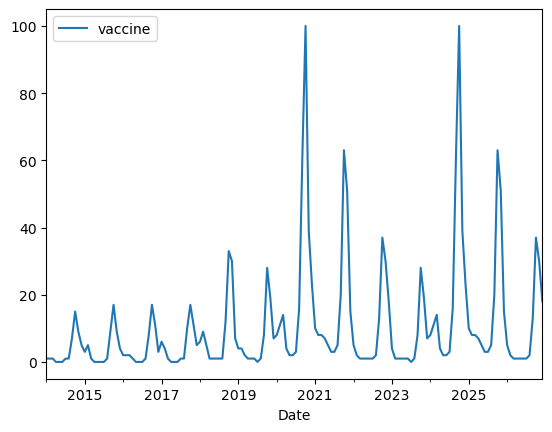

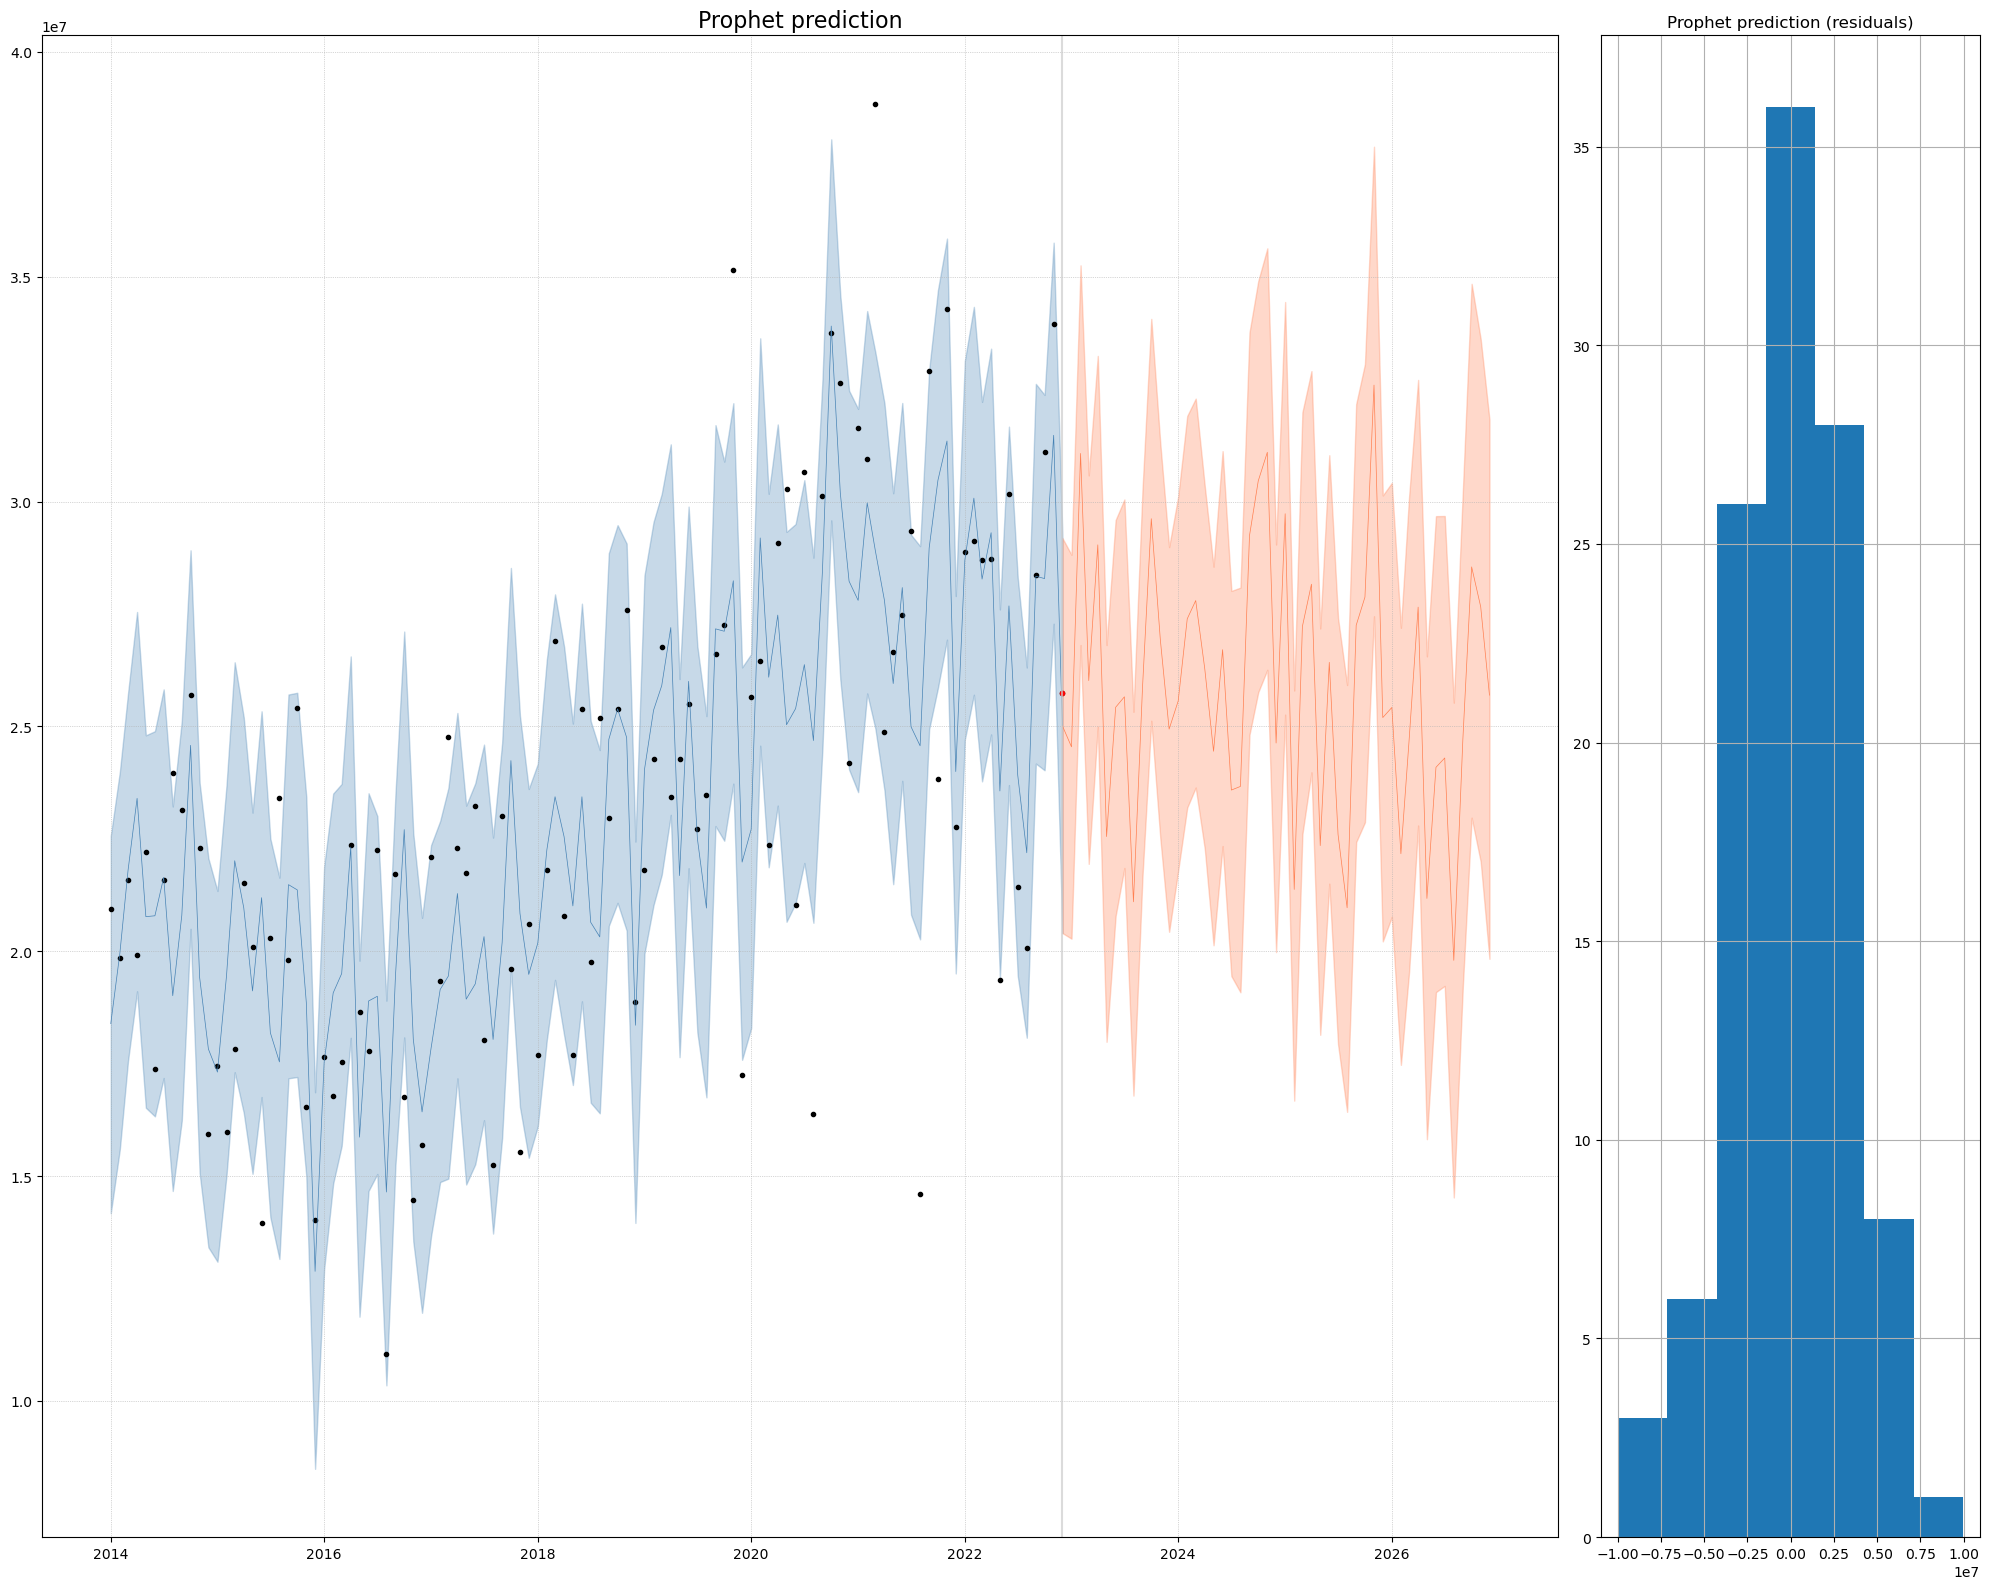

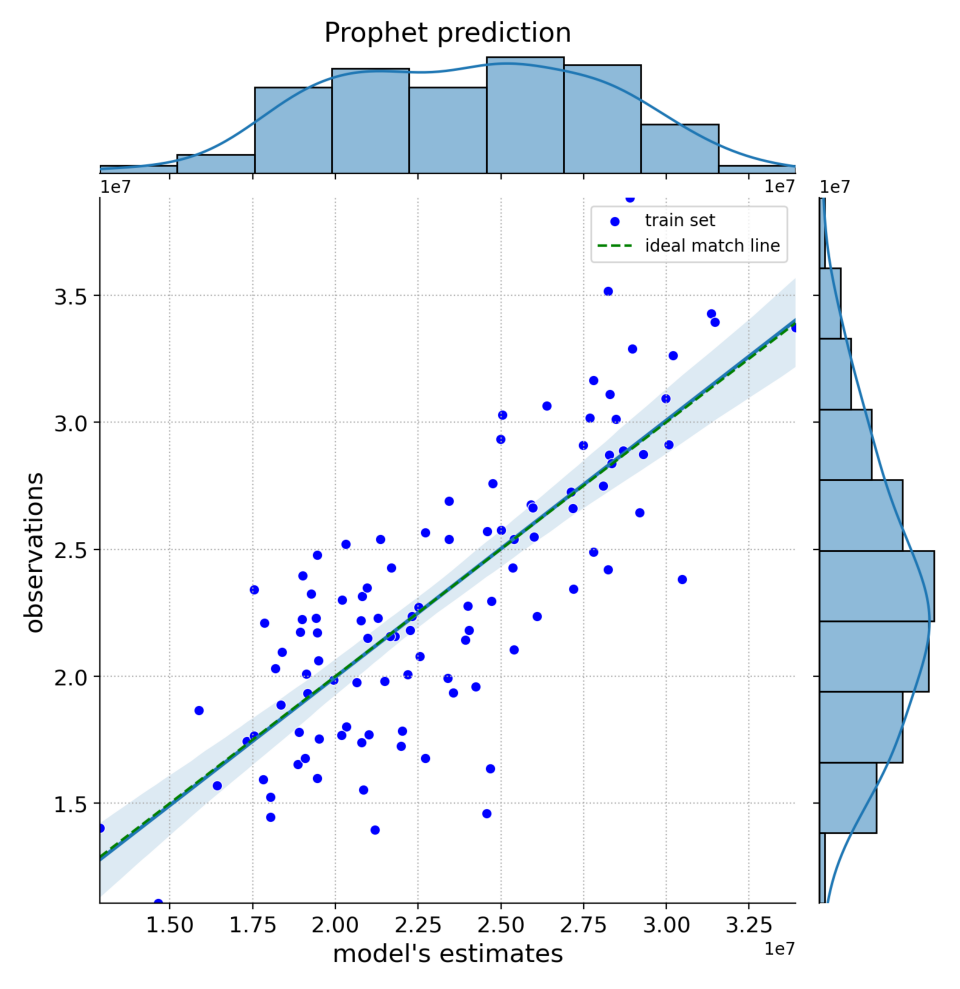

In [111]:
sarima_model = pickle.load(open('sarimax_vaccine.model', 'rb'))
prophet_model = pickle.load(open('prof_forecast.model', 'rb'))

df_sales = pd.read_excel("data_for_clustering.xlsx", parse_dates=True,usecols = "A,B")
df_sales = df_sales.rename({
    "Sales_in_Cz" : "Sales"
}, axis='columns')
#string to date format
df_sales['Date'] = pd.to_datetime(df_sales['Date'],infer_datetime_format=True)
df_sales = df_sales.set_index(['Date'])
df_vaccines = pd.read_csv("vaccines_scenario0.csv", parse_dates=True)

df_vaccines['Date'] = pd.to_datetime(df_vaccines['Date'], format='%Y-%m')
df_vaccines = df_vaccines.set_index('Date')


df_vaccines = df_vaccines.loc[df_sales.index.min():,:]
df_external = pd.concat([df_vaccines], axis=1)

viz_df = make_single_df(prophet_model, df_sales, df_external)
df_vaccines.plot()
plot_single(viz_df)
viz_df[-cutoff_train_test:].drop(columns=['y', 'Sales', 'ds', 'is_cold', 'is_not_cold'])

## Normal scenario

,vaccine,yhat,yhat_lower,yhat_upper
Date,,,,
2023-01-01,4,2.454602e+07,2.056001e+07,2.849856e+07
2023-02-01,1,3.107106e+07,2.698530e+07,3.582547e+07
2023-03-01,1,2.601914e+07,2.169138e+07,3.005041e+07
2023-04-01,1,2.903825e+07,2.456523e+07,3.356173e+07
2023-05-01,0,2.250857e+07,1.840400e+07,2.645959e+07
2023-06-01,0,2.538398e+07,2.139072e+07,2.949019e+07
2023-07-01,5,2.586643e+07,2.131442e+07,2.991348e+07
2023-08-01,2,2.114121e+07,1.689988e+07,2.530960e+07
2023-09-01,7,2.582923e+07,2.175391e+07,3.012522e+07


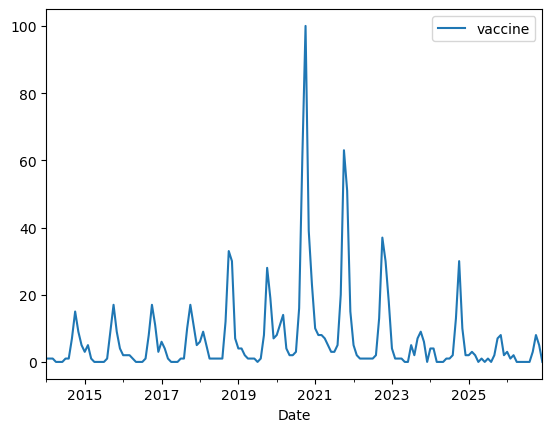

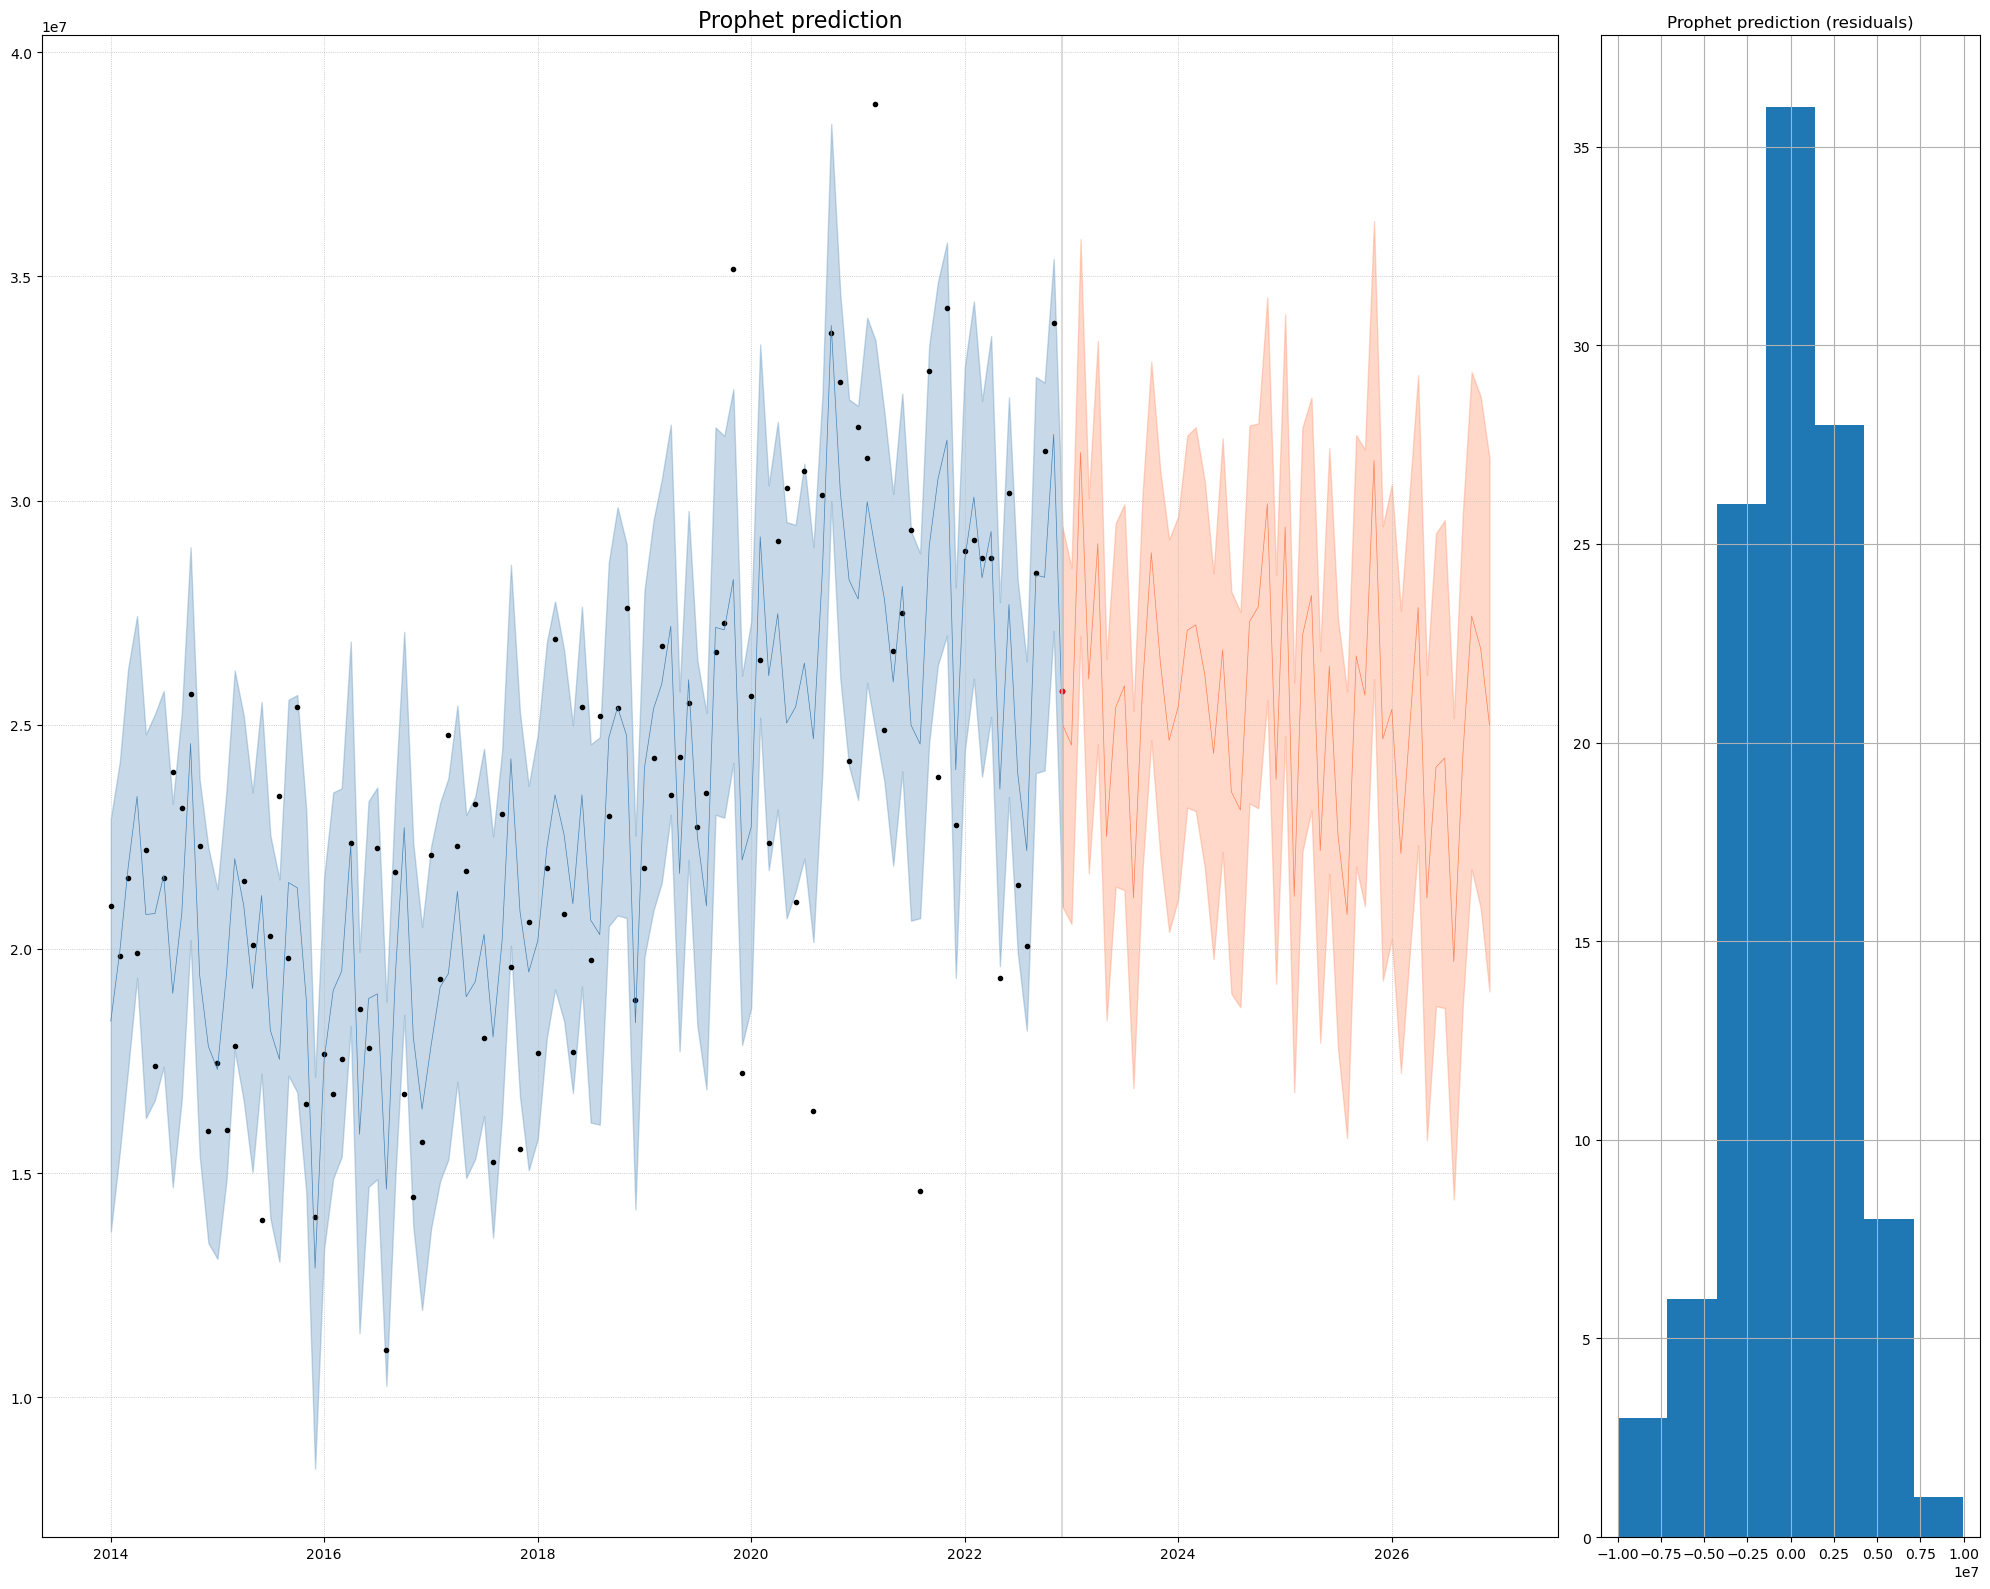

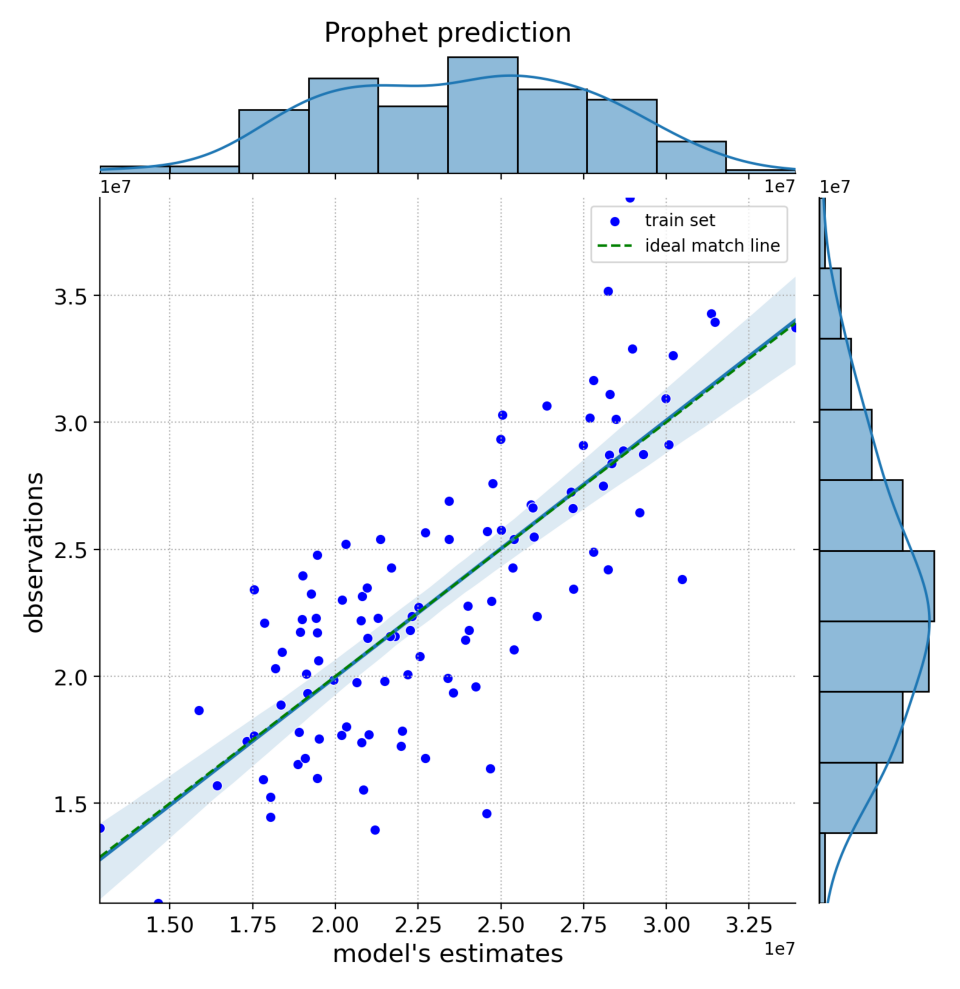

In [112]:
sarima_model = pickle.load(open('sarimax_vaccine.model', 'rb'))
prophet_model = pickle.load(open('prof_forecast.model', 'rb'))

df_sales = pd.read_excel("data_for_clustering.xlsx", parse_dates=True,usecols = "A,B")
df_sales = df_sales.rename({
    "Sales_in_Cz" : "Sales"
}, axis='columns')
#string to date format
df_sales['Date'] = pd.to_datetime(df_sales['Date'],infer_datetime_format=True)
df_sales = df_sales.set_index(['Date'])
df_vaccines = pd.read_csv("vaccines_scenario1.csv", parse_dates=True)

df_vaccines['Date'] = pd.to_datetime(df_vaccines['Date'], format='%Y-%m')
df_vaccines = df_vaccines.set_index('Date')


df_vaccines = df_vaccines.loc[df_sales.index.min():,:]
df_vaccines.plot()
df_external = pd.concat([df_vaccines], axis=1)

viz_df = make_single_df(prophet_model, df_sales, df_external)
plot_single(viz_df)
viz_df[-cutoff_train_test:].drop(columns=['y', 'Sales', 'ds', 'is_cold', 'is_not_cold'])